### Funções

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 15 11:26:44 2019

Visualização dos patches ruidosos a partir do grafo k-NN

"""
import sys
import warnings
import time
import skimage
import statistics
import networkx as nx
import matplotlib.pyplot as plt
import skimage.io
import skimage.measure
import numpy as np
import umap
from numpy import eye
import sklearn.neighbors as sknn
from numba import njit   # just in time compiler (acelera loops)

# Para evitar warning de divisão por zero
warnings.simplefilter(action='ignore')

'''
Espelhamento das bordas da imagem A de maneira simétrica
A função pad do numpy não é supertada pelo numba! (para acelerar com jit)
Substitui a função: img_n = np.pad(ruidosa, ((f, f), (f, f)), 'symmetric')
f é o parâmetro (largura das bordas)
'''
@njit
def mirror(A, f):
    n = A.shape[0]
    m = A.shape[1]

    nlin = A.shape[0] + 2*f          # Altura da nova imagem com borda
    ncol = A.shape[1] + 2*f          # Largura da nova imagem com borda
    B = np.zeros((nlin, ncol))      # Inicializa matriz de saída com zeros

    B[f:nlin-f, f:ncol-f] = A       # Copia imagem original no centro

    # Preenche os quatro cantos com reflexão (espelhamento)
    B[0:f, 0:f] = np.flip(A[0:f, 0:f])                          # 1o quadrante
    B[0:f, ncol-f:ncol] = np.flip(A[0:f, m-f:m])                # 2o quadrante
    B[nlin-f:nlin, 0:f] = np.flip(A[n-f:n, 0:f])                # 3o quadrante
    B[nlin-f:nlin, ncol-f:ncol] = np.flip(A[n-f:n, m-f:m])      # 4o quadrante

     # Preenche as bordas (superior, inferior, esquerda, direita)
    B[0:f, f:ncol-f] = np.flipud(A[0:f, :])             # cima
    B[nlin-f:nlin, f:ncol-f] = np.flipud(A[n-f:n, :])   # baixo
    B[f:nlin-f, 0:f] = np.fliplr(A[:, 0:f])             # esquerda
    B[f:nlin-f, ncol-f:ncol] = np.fliplr(A[:, m-f:m])   # direita
    return B

'''
Extrai todos os patches em uma janela local centrada em (i, j)
f: metade do tamanho do patch
t: raio da janela de busca
'''
@njit
def Extract_patches_local(img, i, j, f, t):
    m, n = img.shape                             # Dimensões da imagem
    tamanho_patch = (2*f + 1)*(2*f + 1)          # Tamanho do vetor de um patch

    img_n = mirror(img, f)                       # Adiciona borda espelhada

    im = i + f;                                  # Compensação por causa do padding
    jn = j + f;

    patch_central = img_n[im-f:(im+f)+1, jn-f:(jn+f)+1].copy()      # Patch central
    central = patch_central.reshape((1, patch_central.shape[0]*patch_central.shape[1]))[-1]

    # Limites da janela de busca
    rmin = max(im-t, f)
    rmax = min(im+t, m+f)
    smin = max(jn-t, f)
    smax = min(jn+t, n+f)

    num_elem = (rmax - rmin + 1)*(smax - smin + 1)  # Total de patches na janela

    dataset = np.zeros((num_elem, tamanho_patch))  # Inicializa matriz de patches
    k = 0                                           # Índice do patch atual no dataset

    for r in range(rmin, rmax+1):
        for s in range(smin, smax+1):
            W = img_n[r-f:(r+f)+1, s-f:(s+f)+1].copy()  # Extrai patch da posição atual
            neighbor = W.reshape((1, W.shape[0]*W.shape[1]))[-1]  # Transforma em vetor
            dataset[k, :] = neighbor.copy()              # Adiciona ao dataset

            if (central == neighbor).all():              # Salva índice do patch central
                source = k

            k = k + 1

    return dataset, source   # Retorna todos os patches da janela e o índice do patch central

'''
Constrói o grafo k-NN a partir de uma matriz de dados (n amostras x m features)
'''
def build_KNN_Graph(dados, k):
    KNNG = sknn.kneighbors_graph(dados, n_neighbors=k, mode='distance')  # Grafo de k-vizinhos com pesos = distâncias
    G = nx.from_scipy_sparse_array(KNNG)  # Converte o grafo para formato NetworkX
    return G

'''
Plota um grafo NetworkX com destaque para um nó central
layout: 'kamada' ou outro (default = spring)
'''
def plota_grafo(G, centro, layout):
    n = len(G.nodes)                            # Número de nós no grafo

    # Escolhe o layout do grafo
    if layout == 'kamada':
        pos = nx.kamada_kawai_layout(G)        # Layout de Kamada-Kawai
    else:
        pos = nx.spring_layout(G)              # Layout de mola (spring)

    # Cria figura
    plt.figure(figsize=(12, 8))
    nx.draw_networkx(G, pos, node_size=35, with_labels=False, width=0.1, alpha=0.7)  # Desenha grafo
    nx.draw_networkx_nodes(G, pos, node_size=35, nodelist=[centro], node_color='red', alpha=0.7)  # Destaque no centro
    plt.show()                                 # Exibe o gráfico



### Plots da localização dos centers

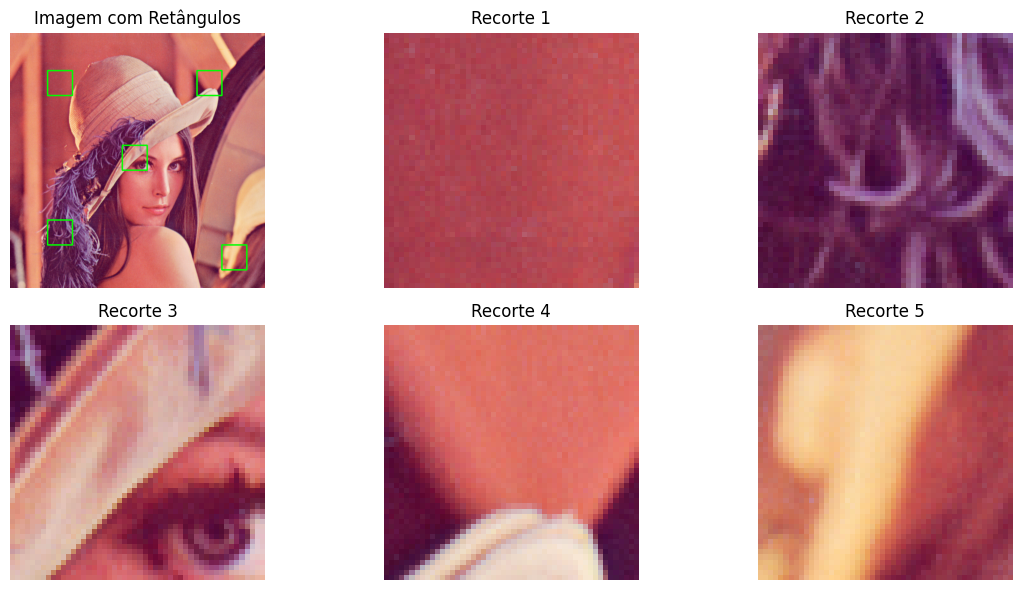

In [6]:
import cv2
import matplotlib.pyplot as plt

def desenhar_e_extrair_quadrados(caminho_imagem, centers, window_size):
    # Lê a imagem do disco
    img = cv2.imread(caminho_imagem)

    if img is None:
        print("Erro ao carregar a imagem.")
        return

    img_com_retangulos = img.copy()
    half_w = window_size[0] // 2
    half_h = window_size[1] // 2

    recortes = []

    for (cx, cy) in centers:
        top_left = (cx - half_w, cy - half_h)
        bottom_right = (cx + half_w, cy + half_h)

        # Desenha o retângulo
        cv2.rectangle(img_com_retangulos, top_left, bottom_right, (0, 255, 0), 2)

        # Recorta o quadrado da imagem original (sem os retângulos)
        recorte = img[
            max(cy - half_h, 0):min(cy + half_h, img.shape[0]),
            max(cx - half_w, 0):min(cx + half_w, img.shape[1])
        ]
        recortes.append(recorte)

    # Converte BGR para RGB para exibir corretamente com matplotlib
    img_rgb = cv2.cvtColor(img_com_retangulos, cv2.COLOR_BGR2RGB)

    # Mostra imagem com retângulos e os recortes
    plt.figure(figsize=(12, 6))

    # Plot principal
    plt.subplot(2, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Imagem com Retângulos")
    plt.axis('off')

    # Subplots dos recortes
    for i, rec in enumerate(recortes):
        plt.subplot(2, 3, i + 2)
        if rec.size > 0:
            rec_rgb = cv2.cvtColor(rec, cv2.COLOR_BGR2RGB)
            plt.imshow(rec_rgb)
        else:
            plt.text(0.5, 0.5, 'Vazio', ha='center')
        plt.title(f"Recorte {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Exemplo de uso
centers = [(100, 100), (100, 400), (250, 250), (400, 100), (450, 450)]
window_size = (50, 50)
caminho_imagem = 'Lenna.png'  # Substitua aqui

desenhar_e_extrair_quadrados(caminho_imagem, centers, window_size)



### Teste com a imagem da Lenna sem ruídos

In [7]:
name = 'Lenna.png'

img = skimage.io.imread(name)

# Checa se imagem é monocromática
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)   # valores convertidos ficam entre 0 e 1
    img = 255*img

img = img.astype(np.uint8)              # Converte para uint8
m, n = img.shape


# Clipa imagem para intervalo [0, 255]
img[np.where(img > 255)] = 255
img[np.where(img < 0)] = 0

# Define parâmetros do filtro NLM
f = 3   # tamanho do patch (2f + 1 x 2f + 1) 5x5
t = 10  # tamanho da janela de busca (2t + 1 x 2t + 1) 21x21

# Problema de valor de contorno: replicar bordas
img_n = np.pad(img, ((f, f), (f, f)), 'symmetric')

#=================================================
# Análise local
#=================================================

# centers = [(100, 100), (100, 400), (250, 250), (400, 100), (450, 450)]
centers = [(561, 431), (428, 586), (385, 296), (260, 328), (223, 394)]


# Número de vizinhos no grafo k-NN
nn = 10

# Remove os patches dentro de cada janela de busca
for k in range(len(centers)):
  # f --> tamanho do patch
  # t --> tamanho da janela de busca  
  patches, centro = Extract_patches_local(img_n, centers[k][0], centers[k][1], f, t)
  # Constrói grafo KNN
  G = build_KNN_Graph(patches, nn)
  # Plota grafo KNN
  plota_grafo(G, centro, 'spring')

ValueError: negative dimensions not allowed

### Gerando ruído com a imagem da Lenna

In [1]:
name = 'Lenna.png'
img = skimage.io.imread(name)

# Checa se imagem é monocromática
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)   # valores convertidos ficam entre 0 e 1
    img = 255*img

img = img.astype(np.uint8)              # Converte para uint8
m, n = img.shape

# Variancia do ruído Gaussiano
sigma = 10
ruido = np.random.normal(0, sigma, (m, n))

# Cria imagem ruidosa
ruidosa = img + ruido

# Clipa imagem para intervalo [0, 255]
ruidosa[np.where(ruidosa > 255)] = 255
ruidosa[np.where(ruidosa < 0)] = 0

# Define parâmetros do filtro NLM
f = 2   # tamanho do patch (2f + 1 x 2f + 1)
t = 8  # tamanho da janela de busca (2t + 1 x 2t + 1)

# Problema de valor de contorno: replicar bordas
img_n = np.pad(ruidosa, ((f, f), (f, f)), 'symmetric')

#=================================================
# Análise local
#=================================================

centers = [(100, 100), (100, 400), (250, 250), (400, 100), (450, 450)]


# Número de vizinhos no grafo k-NN
nn = 10

# Remove os patches dentro de cada janela de busca
for k in range(len(centers)):
  # f --> tamanho do patch
  # t --> tamanho da janela de busca  
  patches, centro = Extract_patches_local(img_n, centers[k][0], centers[k][1], f, t)
  print(f'patches: {patches}')
  print(f'len(patches): {len(patches)}')
  print(f'centro: {centro}') 
  print(f'f: {f}')
  print(f't: {t}')
  # Constrói grafo KNN
  G = build_KNN_Graph(patches, nn)
  # Plota grafo KNN
  plota_grafo(G, centro, 'spring')

NameError: name 'skimage' is not defined

In [150]:
print(len(patches))

print(type(centro))

print(G)

121
<class 'int'>
Graph with 121 nodes and 791 edges


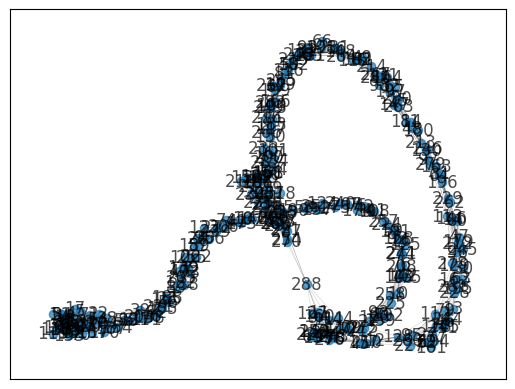

In [13]:
#nx.draw(G, with_labels=True, node_size=30, node_color="lightblue", edge_color="gray")
nx.draw_networkx(G, pos = nx.spring_layout(G), node_size=35, with_labels=True, width=0.1, alpha=0.7)
#nx.draw_networkx_nodes(G, pos = nx.spring_layout(G), node_size=30, nodelist=[centro], node_color='red', alpha=0.7)



In [4]:
# Definir os nós de origem e destino
origem = 1
destino = 4

caminho = nx.dijkstra_path(G, origem, destino, weight='weight')
distancia = nx.dijkstra_path_length(G, origem, destino, weight='weight')

# Exibir os resultados
print("Menor caminho:", caminho)
print("Distância:", distancia)

Menor caminho: [1, 19, 4]
Distância: 140.29290591068306


In [5]:
# Definir os nós de origem e destino
origem = 1
destino = 4

caminho = nx.dijkstra_path(G, origem, destino, weight='weight')
distancia = nx.dijkstra_path_length(G, origem, destino, weight='weight')

# Exibir os resultados
print("Menor caminho:", caminho)
print("Distância:", distancia)

Menor caminho: [1, 19, 4]
Distância: 140.29290591068306
